In [114]:
# so modules are automatically reloaded when they are changed
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns


from mynotebooks.results_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get Test Results

In [115]:
ROOT = ''

# attribute = 'Age' 
# col_name = 'Age_multi' 

attribute = 'Centre'
col_name = 'assessment_centre'

# attribute = 'Random'
# col_name = 'Random'

# attribute = 'Sex'
# col_name = 'Sex'

experiment_folder = os.path.join(ROOT,attribute,'InceptionV3')
models = os.listdir(experiment_folder)
models = (sorted(models,key=str.casefold))
data_folder = ''
random_seed_folders = ['42','43','44']
class_name = 'adj-bp' 

path_to_test_splits = os.path.join(ROOT,'data/ukbb-ret',data_folder,'splits','test-'+class_name+'.csv')

subgroups = ['Age_multi','Sex','bmi_cat','alcohol','assessment_centre','deprivation_index','ethnicity','gen_ethnicity']

all_models_dict = {}

for i,model in enumerate(models):
    all_models_dict[model] = {}
    list_overall_test_results=[]
    list_disparities_test_results=[]
    list_subgroup_results=[]
    test_preds_dict = {}
    for i,random_seed in enumerate(random_seed_folders):
        results_folder = os.path.join(ROOT,experiment_folder,model,data_folder,random_seed)
        if os.path.isdir(results_folder):

            if model == 'recalibration':
                pred_file = [x for x in os.listdir(results_folder) if 'pred.csv' in x and 'train_' not in x and 'val' not in x][0] # account for different names
                test_preds = pd.read_csv(os.path.join(results_folder,pred_file))
                test_preds['correct'] = np.where(test_preds['pred'] == test_preds['binary_label'],1,0)
                test_preds['FP'] = np.where((test_preds['binary_label']==0) & (test_preds['pred']==1),1,0)
                test_preds['FN'] = np.where((test_preds['binary_label']==1) & (test_preds['pred']==0),1,0)
                test_preds['TP'] = np.where((test_preds['binary_label']==1) & (test_preds['pred']==1),1,0)
                test_preds['TN'] = np.where((test_preds['binary_label']==0) & (test_preds['pred']==0),1,0)

            else:

                pred_file = [x for x in os.listdir(results_folder) if 'pred.csv' in x and 'train_' not in x and 'val' not in x][0] # account for different names

                test_preds = preprocess_ukbb_data(os.path.join(results_folder,pred_file),path_to_test_splits)
                test_preds['correct'] = np.where(test_preds['pred'] == test_preds['binary_label'],1,0)

            test_results_df = make_test_results_df([test_preds],subgroups)
            test_results_df.set_index('Subgroup',inplace=True)
            overall_test_results_df = pd.DataFrame(test_results_df.iloc[0][['Test Acc','Test AUC','Test Precision','Test Recall','Test TNR']])
            overall_test_results_df.rename(columns={'Age_multi':'Overall'},inplace=True)
            disparities_test_results_df = pd.DataFrame(test_results_df[[x for x in test_results_df.columns if 'Gap' in x or 'Min' in x]])

            # get subgroup results
            train_acc_list, train_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
            train_auc_list = get_subgroup_auc([test_preds],col_name)
            subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_auc':train_auc_list[-1],'test_tnr': train_tnr_list[-1]})

            list_overall_test_results.append(overall_test_results_df)
            list_disparities_test_results.append(disparities_test_results_df)
            list_subgroup_results.append(subgroup_df)

            test_preds_dict[random_seed] = test_preds

        else:
            print(f"{results_folder} is not a directory.")
    # get mean and sd for each random seed and then add to dict
    all_overall_test_results = pd.concat(x.T for x in list_overall_test_results)
    mean_std = all_overall_test_results.apply(pd.to_numeric).describe().loc[['mean', 'std']]

    all_disparities_test_results = pd.concat(x for x in list_disparities_test_results)
    disparities_mean = all_disparities_test_results.groupby(level=0).mean()
    disparities_std = all_disparities_test_results.groupby(level=0).std()

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    all_models_dict[model] = {'overall_test_results':mean_std,'disparities_test_results':(disparities_mean,disparities_std),'subgroup_results':(subgroup_mean,subgroup_std), 'test_preds':test_preds_dict}

/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/mynotebooks/results_utils.py:51: RuntimeWarning: invalid value encountered in divide
  score = f1+np.multiply(0.25,tnrs)


## Overall performance

In [116]:
overall_results_df = pd.DataFrame(pd.concat([all_models_dict[model]['overall_test_results'].loc['mean'] for model in models],axis=1,keys=models).round(3)).T
overall_std_df = pd.DataFrame(pd.concat([all_models_dict[model]['overall_test_results'].loc['std'] for model in models],axis=1,keys=models).round(3)).T
overall_results_df

,Test Acc,Test AUC,Test Precision,Test Recall,Test TNR
baseline,0.731,0.705,0.814,0.829,0.443
DomainInd,0.733,0.702,0.811,0.838,0.428
GroupDRO,0.736,0.700,0.809,0.845,0.415
LNL,0.724,0.637,0.783,0.872,0.290
ODR,0.733,0.680,0.801,0.855,0.376
recalibration,0.747,0.705,0.812,0.859,0.418
resampling,0.739,0.703,0.807,0.854,0.403
resamplingSWAD,0.740,0.700,0.806,0.858,0.396
SWAD,0.734,0.710,0.814,0.835,0.439


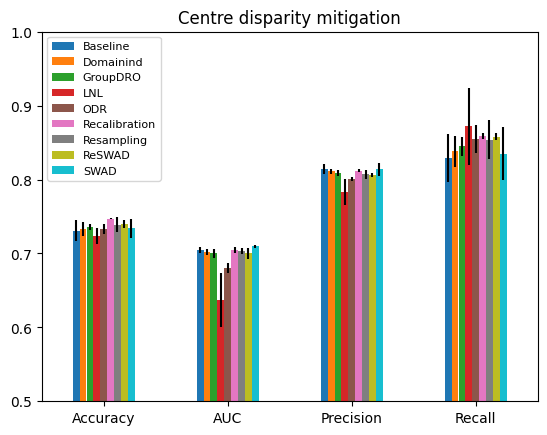

In [117]:
overall_results_df = overall_results_df[['Test Acc','Test AUC','Test Precision','Test Recall']] # with TNR hard to see differences in other cols bc so much lower
# capitalise first letter of each word
overall_results_df.index = ['Baseline', 'Domainind', 'GroupDRO', 'LNL', 'ODR', 'Recalibration',
       'Resampling', 'ReSWAD', 'SWAD']
overall_std_df.index = ['Baseline', 'Domainind', 'GroupDRO', 'LNL', 'ODR', 'Recalibration',
         'Resampling', 'ReSWAD', 'SWAD']
overall_results_df.columns = ['Accuracy', 'AUC', 'Precision', 'Recall']
overall_std_df.columns = ['Accuracy', 'AUC', 'Precision', 'Recall','TNR']
ax = overall_results_df.T.plot(kind='bar',ylim=(0.5,1.0),yerr=overall_std_df.T,rot=0,colormap ='tab10',title='Centre disparity mitigation')
ax.legend(prop={'size': 8})


In [119]:
auc_df = overall_results_df['AUC']
auc_std_df = overall_std_df ['AUC']

attribute_disparities_df = pd.DataFrame(pd.concat([all_models_dict[model]['disparities_test_results'][0].loc[col_name] for model in models],axis=1,keys=models).round(3)).T
attribute_disparities_std_df = pd.DataFrame(pd.concat([all_models_dict[model]['disparities_test_results'][1].loc[col_name] for model in models],axis=1,keys=models).round(3)).T
auc_disparities_df = attribute_disparities_df['Test Min AUC']
auc_disparities_std_df = attribute_disparities_std_df['Test Min AUC']
auc_disparities_df.index = ['Baseline', 'Domainind', 'GroupDRO', 'LNL', 'ODR', 'Recalibration',
       'Resampling', 'ReSWAD', 'SWAD']
auc_disparities_std_df.index = ['Baseline', 'Domainind', 'GroupDRO', 'LNL', 'ODR', 'Recalibration',
       'Resampling', 'ReSWAD', 'SWAD']

models = ['Baseline', 'Domainind', 'GroupDRO', 'LNL', 'ODR', 'Recalibration',
       'Resampling', 'ReSWAD', 'SWAD']

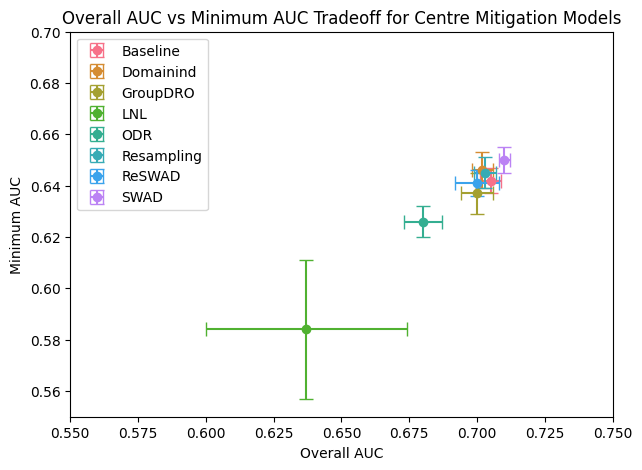

In [122]:
colors = sns.color_palette("husl", len(models))
if 'Recalibration' in models:
    models.remove('Recalibration') # because AUC is the same as for baseline
plt.figure(figsize=(7, 5))
for i, model in enumerate(models):
    plt.errorbar(auc_df[model], auc_disparities_df[model], 
                 xerr=auc_std_df[model], yerr=auc_disparities_std_df[model],
                 fmt='o', capsize=5, color=colors[i], label=model)

plt.xlabel('Overall AUC')
plt.xlim([0.55, 0.75])
plt.ylim([0.55, 0.70])
plt.ylabel('Minimum AUC')
plt.title('Overall AUC vs Minimum AUC Tradeoff for Centre Mitigation Models')
plt.legend()
plt.show()

## Disparities

### Attribute disparities (eg the ones which are trying to be mitigated)

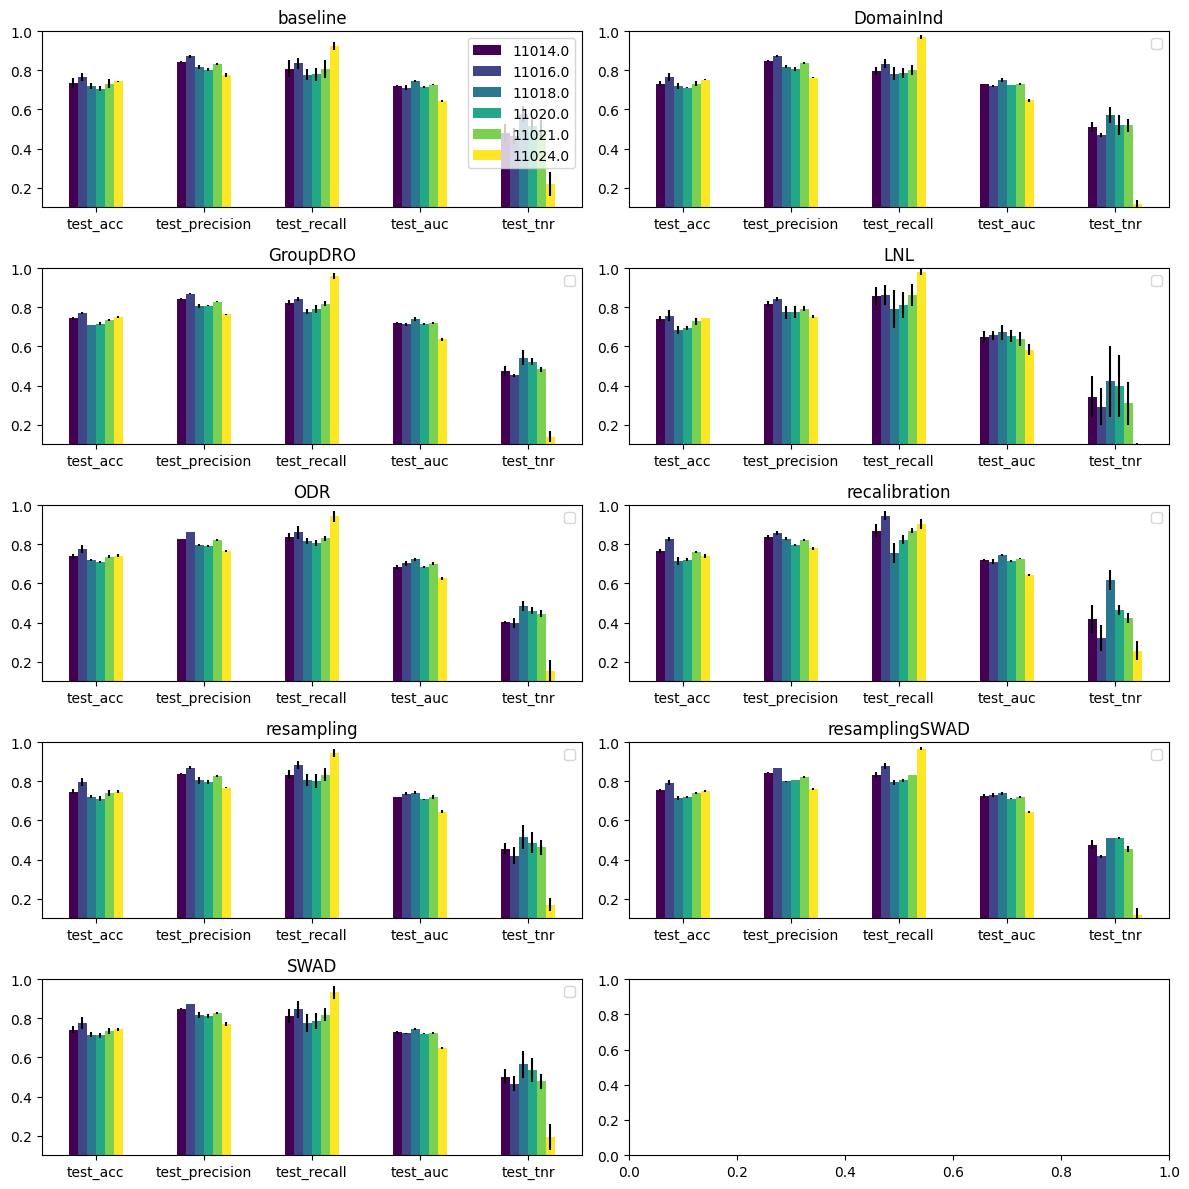

In [100]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))
axs = axs.flatten()

for i, model in enumerate(models):
    all_models_dict[model]['subgroup_results'][0].T.plot(kind='bar', ylim=(0.1,1.0), yerr=all_models_dict[model]['subgroup_results'][1].T, cmap='viridis', ax=axs[i])
    axs[i].set_title(model)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0)  # Make x-axis labels horizontal
    # Show legend only on the first subplot
    if i == 0:
        axs[i].legend()
    else:
        axs[i].legend('')

plt.tight_layout()
plt.show()
    

In [118]:
centre_attribute_disparities_df = pd.DataFrame(pd.concat([all_models_dict[model]['disparities_test_results'][0].loc[col_name] for model in models],axis=1,keys=models).round(3)).T
centre_attribute_disparities_std_df = pd.DataFrame(pd.concat([all_models_dict[model]['disparities_test_results'][1].loc[col_name] for model in models],axis=1,keys=models).round(3)).T

centre_attribute_disparities_std_df = ' (' + centre_attribute_disparities_std_df.astype(str) + ')'
centre_attribute_disparities_df = centre_attribute_disparities_df.astype(str)
centre_attribute_disparities_df = centre_attribute_disparities_df + centre_attribute_disparities_std_df
centre_attribute_disparities_df.rename(columns={'Test Acc Gap':'Accuracy Gap','Test Min Acc':'Min Accuracy','Test Min AUC':'Min AUC','Test AUC Gap':'AUC Gap','Test Min Precision':'Min Precision','Test Precision Gap':'Precision Gap','Test Min Recall':'Min Recall','Test Recall Gap':'Recall Gap','Test TNR Gap':'TNR Gap','Test Min TNR':'Min TNR'},inplace=True)
centre_attribute_disparities_df.drop(columns=['Min TNR', 'TNR Gap'],inplace=True)
centre_attribute_disparities_df

,Accuracy Gap,Min Accuracy,AUC Gap,Min AUC,Precision Gap,Min Precision,Recall Gap,Min Recall
baseline,0.061 (0.012),0.706 (0.013),0.104 (0.004),0.642 (0.005),0.097 (0.012),0.776 (0.01),0.149 (0.013),0.775 (0.029)
DomainInd,0.055 (0.019),0.712 (0.004),0.106 (0.005),0.646 (0.007),0.111 (0.007),0.763 (0.002),0.189 (0.027),0.78 (0.034)
GroupDRO,0.061 (0.006),0.71 (0.001),0.105 (0.003),0.637 (0.008),0.106 (0.002),0.765 (0.003),0.183 (0.009),0.779 (0.014)
LNL,0.082 (0.007),0.682 (0.015),0.089 (0.017),0.584 (0.027),0.092 (0.004),0.751 (0.01),0.197 (0.071),0.785 (0.088)
ODR,0.065 (0.017),0.71 (0.006),0.097 (0.003),0.626 (0.006),0.098 (0.006),0.765 (0.006),0.137 (0.023),0.808 (0.015)
recalibration,0.118 (0.022),0.711 (0.015),0.104 (0.004),0.642 (0.005),0.079 (0.011),0.781 (0.007),0.19 (0.071),0.755 (0.05)
resampling,0.085 (0.013),0.712 (0.011),0.098 (0.013),0.645 (0.006),0.101 (0.006),0.769 (0.003),0.146 (0.022),0.799 (0.033)
resamplingSWAD,0.082 (0.008),0.712 (0.008),0.097 (0.005),0.641 (0.005),0.107 (0.005),0.762 (0.006),0.174 (0.019),0.793 (0.012)
SWAD,0.06 (0.019),0.715 (0.013),0.095 (0.009),0.65 (0.005),0.102 (0.007),0.772 (0.009),0.156 (0.016),0.776 (0.046)
